In [196]:
import json
import numpy as np
import matplotlib.pyplot as plt
import uproot
import matplotlib as mpl
import math

from scipy.optimize import curve_fit
from scipy import interpolate, special
from scipy.stats import norm as normal

In [197]:
# MPL config
mpl.rc('font', size=14)

dosave = False
savedir = "/home/london/icarus/field_response/figs/"

# Clear figures in main loop
CLEARPLT = False

In [198]:
# Configuration

# Plane
IPLANE = 2

# Filename for WC configuration containing electron paths
WCpaths_filename = "./garfield-icarus-fnal-rev1.json"
# Time spacing in file
time = np.linspace(0,100,1000, endpoint=False)

# Filename and histogram with electronics response
fER = "elecResp_ICARUS.root"
fERh = uproot.open(fER)["ER"]

# Filename with simulated signal response
SR_filename = "../mc/WFresults_Plane%i_WC.root" % IPLANE

# Whether to include Guassian broadening in fit
FITGAUS = False

# Include skew?
FITSKEW = False

# What range of time to fit the response
FIT_PERIOD = 5

# What range of time to plot the response
PLT_PERIOD = 10

# Plot various things
PLTPATHS = False # electron paths
PLTFR = False # field response
PLTSR = False # signal response
PLTFIT = False # fit

uhf = uproot.open(SR_filename)

ER_val = fERh.values()
ER_time = fERh.axis().centers()
ER = interpolate.interp1d(ER_time, ER_val, kind="linear", bounds_error=False, fill_value=0)

In [217]:
# Helper functions
def convolve(f1, f2):
    '''
    Return the simple convolution of the two arrays using FFT+mult+invFFT method.
    '''
    # fftconvolve adds an unwanted time shift
    #from scipy.signal import fftconvolve
    #return fftconvolve(field, elect, "same")
    s1 = np.fft.fft(f1)
    s2 = np.fft.fft(f2)
    sig = np.fft.ifft(s1*s2)

    return np.real(sig)

def gaus(t, sigma):
    return np.exp(-t**2/(2*sigma**2))

def skewgaus(t, sigma, skew):
    skew = -1/skew
    return gaus(t, sigma)*(1 + special.erf(skew*t/np.sqrt(2)))

def agaus(t, sigmalo, sigmahi):
    return np.exp(-t**2/(2*sigmalo**2))*(t < 0) + np.exp(-t**2/(2*sigmahi**2))*(t >= 0)

def norm(v, vnorm=None):
    if vnorm is None:
        vnorm = v
    if IPLANE == 2:
        return v / vnorm.max()
    else:
        return v / np.abs(vnorm.min())
    
def center(t, v):
    if IPLANE == 0: # Ind-0 -- center on down-peak
        return t - t[np.argmin(v)]
    elif IPLANE == 2: # Collection -- center on peak
        return t - t[np.argmax(v)]
    else: # Ind-1 -- center on zero-cross
        center_ind = np.argmin(np.abs(v[np.argmax(v):np.argmin(v)])) + np.argmax(v)
        return t - t[center_ind]

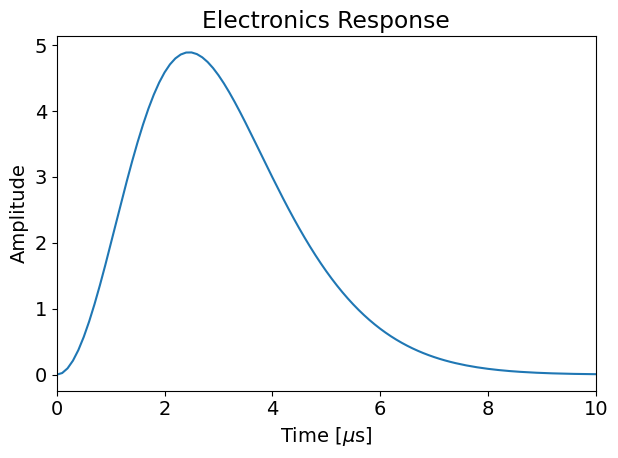

In [218]:
def electronics_response(t,width):
    mu = 0
    amp = 10.
    y = (t>=mu)*amp*(1-np.exp(-0.5*(0.9*(t-mu)/width)**2))*np.exp(-0.5*(0.5*(t-mu)/width)**2)
    return y

er_width = 1.3
er = interpolate.interp1d(ER_time, norm(electronics_response(np.array(ER_time),er_width)), kind="linear", bounds_error=False, fill_value=0)

ratio = interpolate.interp1d(ER_time, ER(ER_time)/electronics_response(ER_time,er_width), kind="linear", bounds_error=False, fill_value=0)

plt.plot(time, electronics_response(time,er_width))
plt.xlabel("Time [$\\mu$s]")
plt.ylabel("Amplitude")
plt.xlim([0, 10])
plt.title("Electronics Response")
plt.tight_layout()

if dosave: plt.savefig(savedir + "elecResp.pdf")

In [219]:
dat = json.load(open(WCpaths_filename))

driftV = dat["FieldResponse"]["speed"]*1e3 # mm/us

thispaths = dat["FieldResponse"]["planes"][IPLANE]["PlaneResponse"]["paths"]

pitchpos_f = [path["PathResponse"]["pitchpos"] for path in thispaths] # mm

paths_f = [np.array(path["PathResponse"]["current"]["array"]["elements"])
             for path in thispaths]


pitchpos = []
paths = []

for i, (ppos, path) in enumerate(zip(pitchpos_f, paths_f)):
    pitchpos.append(ppos)
    paths.append(path)
    if -ppos not in pitchpos_f:
        pitchpos.append(-ppos)
        paths.append(path)
    # handle boundary between (half-)wires
    else:
        paths[-1] = tuple([paths[-1], paths_f[pitchpos_f.index(-ppos)]])
        
pitchpos, paths = zip(*sorted(zip(pitchpos, paths), key=lambda pair: pair[0]))
pitchpos = np.array(pitchpos)

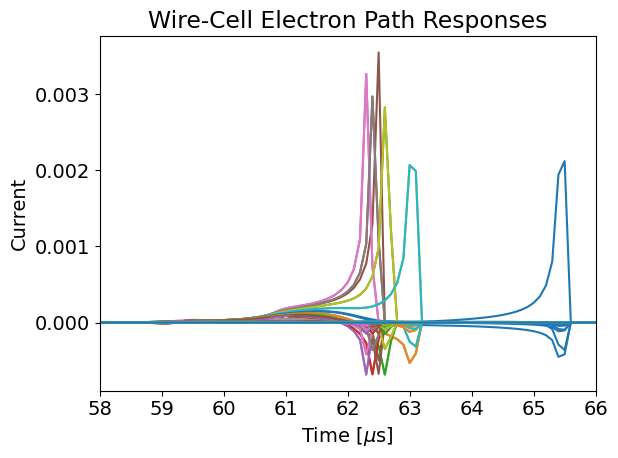

In [220]:
for p, path in zip(pitchpos, paths):
    if isinstance(path, tuple):
        plt.plot(time, -path[0])
    else:
        plt.plot(time, -path)
    
plt.title("Wire-Cell Electron Path Responses")
plt.xlabel("Time [$\\mu$s]")
plt.ylabel("Current")

plt.xlim([58 - 2*(2-IPLANE), 66 - 2*(2-IPLANE)])
plt.tight_layout()

if dosave: plt.savefig(savedir + "pathResp.pdf")

In [221]:
if IPLANE == 2:
    txt_x = 0.05
else:
    txt_x = 0.55

In [244]:
#Pick plane, load in data, etc

# Plane
IPLANE = 2

# Filename with measured signal response
#data_filename = "../mc/WFresults_Plane%i_WC.root" % IPLANE
data_filename = "../data/run_8749/WFresults_Plane%i_EE.root" % IPLANE
uhf = uproot.open(data_filename)

#Create arrays over angle bins to store angle info, data filenames, data products
data_hists = []
data_err_hists = []
data_err_vecs = []
data_times = []
data_when_list = []
data_fit_list = []
angle_min = 20
angle_max = 80
angle_increment = 2
angles = np.array(list(range(angle_min, angle_max, angle_increment))) # 20-60, inclusive
for angle in angles:
    thlo = angle_min + math.floor((angle-angle_min)/angle_increment)*angle_increment
    thhi = thlo + angle_increment
    data = uhf["AnodeRecoHist1D_%ito%i" % (thlo, thhi)]
    data_err = uhf["AnodeTrackUncertHist2D_%ito%i" % (thlo, thhi)].to_numpy()[0][5]
    data_hists.append(data)
    data_err_vecs.append(data_err)
    data_times.append(center(data_hists[-1].axis().centers(), data_hists[-1].values()))
    data_when_list.append(np.abs(data_times[-1]) < PLT_PERIOD)
    data_fit_list.append(np.abs(data_times[-1]) < FIT_PERIOD)
    

In [257]:
#Helper function to compute chi2
def calc_chi2(pred, meas, err):
    vals = np.divide(meas-pred,err)
    chi2 = np.sum(np.multiply(vals,vals))
    return chi2

def contains(array,x):
    bool_array = (array==x)
    ncontains = sum(bool_array.astype(int))
    return (ncontains != 0)

#returns the set of elements in the input array - no duplicates
def to_set(array):
    as_set = []
    for i in range(len(array)):
        if(not contains(as_set,array[i])):
            as_set.append(array[i])
    return np.array(as_set)

#Finds the index where a strictly increasing array first goes above 0
def find_zero(array):
    for i,val in enumerate(array):
        if (val>=0):
            return i
        
def scale_time(t,sl,sr):
    t0_index = find_zero(t)
    scaled_time = np.zeros(len(t))
    scaled_time[:t0_index] = t[:t0_index]*sl
    scaled_time[t0_index:] = t[t0_index:]*sr
    return scaled_time

In [258]:
#Function that produces the complete toy mc waveform simulation - interpolated field response, signal response, and gaussian convolution
def mc_waveform(t0,mu,er_width,scale_time_left,scale_time_right):    
    
    #Convert from prepared time (containing angle info) to actual time
    angle_bin = np.floor(t0/(2*PLT_PERIOD)).astype(int)
    angle_bin_set = to_set(angle_bin)
    angle_bin_index = np.zeros(len(angle_bin),dtype=int)
    for i in range(len(angle_bin_set)):
        angle_bin_index += i*(angle_bin==angle_bin_set[i]).astype(int)
    
    t = (t0 % (2*PLT_PERIOD)) - PLT_PERIOD
    angle = (angles[angle_bin_set]+angles[angle_bin_set+1])/2
    
    # interpolate the paths with a finer spacing (0.03mm)
    # avoid edge effects by spacing in between the discontinuities in the paths (every 1.5mm)
    pitchpos_interp = np.linspace(pitchpos.min(), pitchpos.max(), 2101) + 0.015
    paths_interp = []

    for i, p in enumerate(pitchpos_interp):
        i_pitchpos = int((p - pitchpos[0]+1e-6) / (pitchpos[1] - pitchpos[0]))
        if i_pitchpos == len(pitchpos) - 1:
            path = paths[i_pitchpos]
        else:
            F1 = paths[i_pitchpos]
            F2 = paths[i_pitchpos+1]
        
            # handle boundary between (half-)wires
            if isinstance(F1, tuple):
                if p > pitchpos[i_pitchpos]:
                    F1 = F1[0]
                else:
                    F1 = F1[1]
            if isinstance(F2, tuple):
                if p > pitchpos[i_pitchpos+1]:
                    F2 = F2[0]
                else:
                    F2 = F2[1]
                
            interp = (pitchpos[i_pitchpos+1] - p)/(pitchpos[1] - pitchpos[0])
            path = F1*interp + F2*(1-interp)

        paths_interp.append(path)
        
    # Compute the interpolated field response at this track angle
    thxw = angle*np.pi/180
    #shift = (np.tan(thxw)*pitchpos_interp/driftV/dt).astype(int)
    shift = (np.outer(np.tan(thxw),pitchpos_interp/driftV/dt)).astype(int)
    shifted_paths = []
    for i in range(len(angle)):
        shifted_paths_angle = []
        for j in range(len(paths_interp)):
            s = shift[i][j]
            shifted_paths_angle.append(np.roll(paths_interp[j], s))
            if s < 0:
                shifted_paths_angle[j][s:] = 0
            if s > 0:
                shifted_paths_angle[j][:s] = 0
        shifted_paths.append(shifted_paths_angle)
    
    #Sum the field responses over drift offset to get the overall field response
    #field_response = -sum(shifted_paths)
    field_response = []
    for i in range(len(angle)):
        field_response.append(-sum(shifted_paths[i]))
        
    #Convolve with electronics response and Gaussian smearing
    gaus_sigma = np.sqrt(0.30**2 + (np.tan(angle)*0.35)**2)
    
    SR_gaus_list = []
    timeplt_list = []
    mc_val_interp_list = []
    for i in range(len(angle)):
        SR = convolve(field_response[i], electronics_response(time,er_width))
        SR_gaus_list.append(norm(convolve(SR, gaus(time,gaus_sigma[i]))))
        centered_time = center(time, SR_gaus_list[i])
        scaled_centered_time = scale_time(centered_time,scale_time_left,scale_time_right)
        timeplt_list.append(scaled_centered_time)
        mc_val_interp_list.append(interpolate.interp1d(timeplt_list[-1] + mu, SR_gaus_list[-1], kind="linear", bounds_error=False, fill_value=0))
        
    #Interpolate response
    mc_val_interp_arr = np.array(mc_val_interp_list)
    mc_val_interpolations = mc_val_interp_arr[angle_bin_index]
    
    vals = []
    for i in range(len(t)):
        vals.append(mc_val_interpolations[i](t[i]))
    return np.array(vals)

fitting
[0.09018141 1.32233297 1.07903048 0.90656022]
pred
chi2/ndf
938.6942161799484 / 175


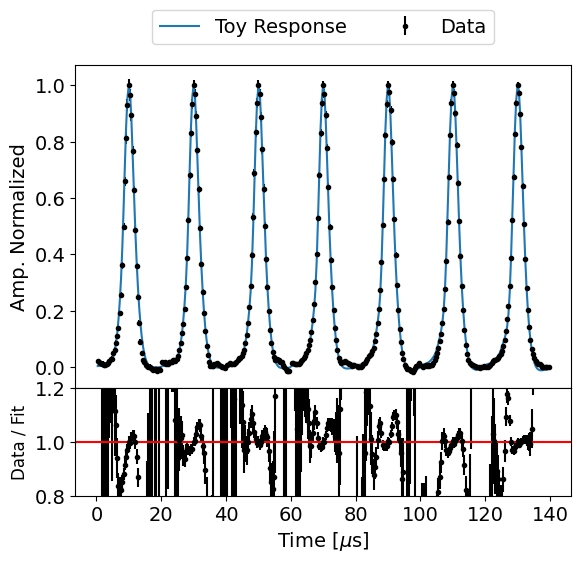

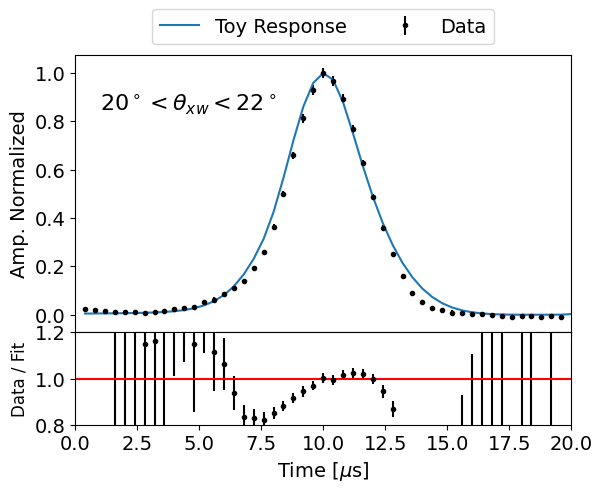

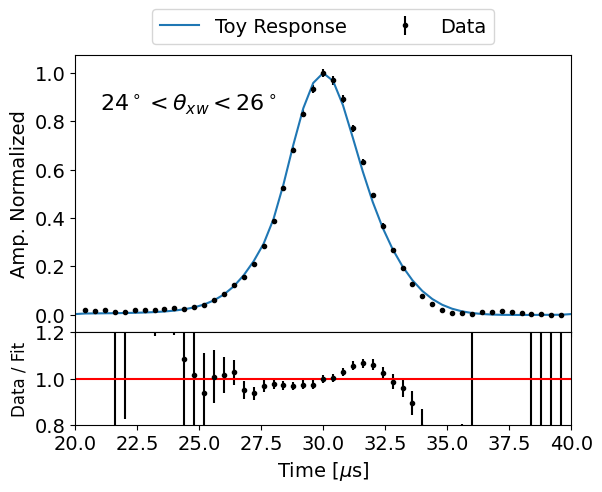

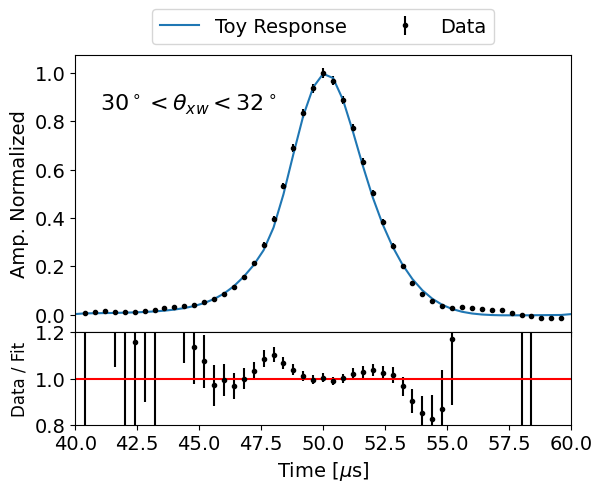

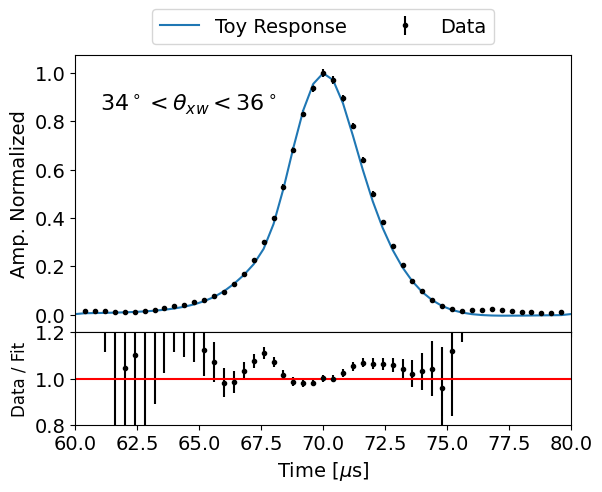

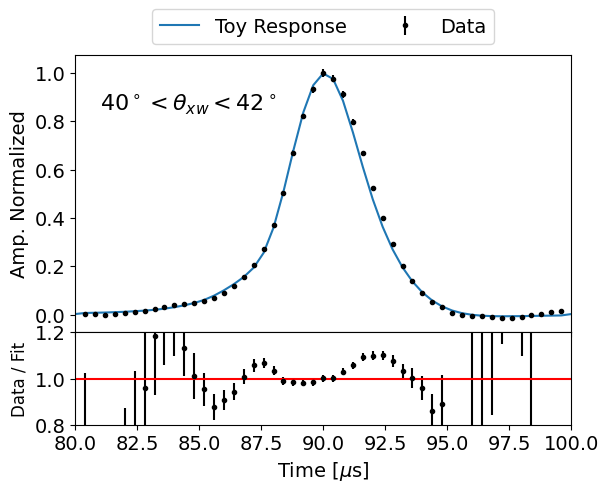

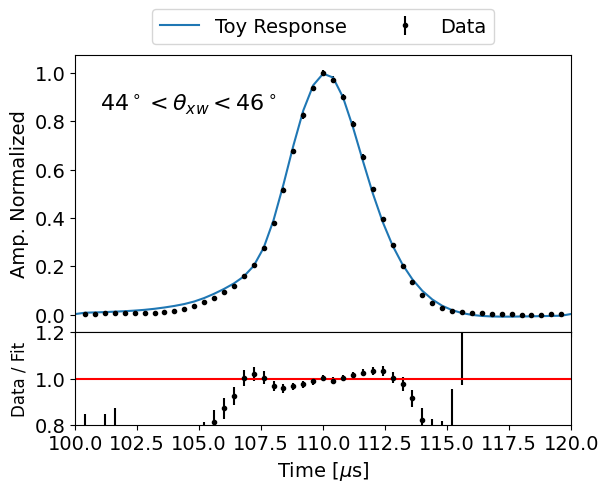

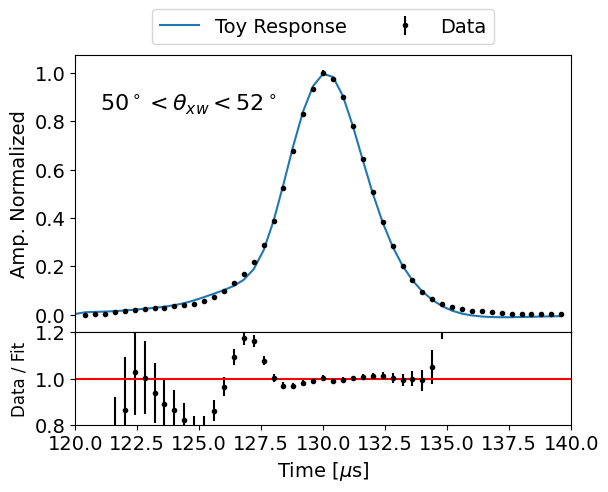

In [259]:
#Create arrays for time,data in fit and plot regions
time_fitregion_list = []
time_plotregion_list = []
time_plotregion_noshift_list = []
time_fitregion_mc_list = []
time_plotregion_mc_list = []

data_fitregion_list = []
data_plotregion_list = []
data_fitregion_norm_list = []
data_plotregion_norm_list = []

data_err_fitregion_list = []
data_err_plotregion_list = []
data_err_fitregion_norm_list = []
data_err_plotregion_norm_list = []


#Loop over angles
angles_list = [20,25,30,35,40,45,50]
nangles = len(angles)
for i_angle in range(len(angles_list)):
    angle = angles_list[i_angle]
    i_angle_mc = np.floor((angle-angle_min)/angle_increment)
    thlo = angle_min + math.floor((angle-angle_min)/angle_increment)*angle_increment
    thhi = thlo + angle_increment
    time_offset = (PLT_PERIOD*(1+2*i_angle))
    time_angle_offset = (PLT_PERIOD*(1+2*i_angle_mc))
    
    time_fitregion_list.append(data_times[i_angle][data_fit_list[i_angle]]+time_offset)
    time_plotregion_list.append(data_times[i_angle][data_when_list[i_angle]]+time_offset)
    time_plotregion_noshift_list.append(data_times[i_angle][data_when_list[i_angle]])
    time_fitregion_mc_list.append(data_times[i_angle][data_fit_list[i_angle]]+time_angle_offset)
    time_plotregion_mc_list.append(data_times[i_angle][data_when_list[i_angle]]+time_angle_offset)

    data_fitregion_list.append(data_hists[i_angle].values()[data_fit_list[i_angle]])
    data_plotregion_list.append(data_hists[i_angle].values()[data_when_list[i_angle]])
    data_fitregion_norm_list.append(norm(data_fitregion_list[-1]))
    data_plotregion_norm_list.append(norm(data_plotregion_list[-1]))

    data_err_fitregion_list.append(data_err_vecs[i_angle][data_fit_list[i_angle]])
    data_err_plotregion_list.append(data_err_vecs[i_angle][data_when_list[i_angle]])
    data_err_fitregion_norm_list.append(norm(data_err_fitregion_list[-1],data_fitregion_list[-1]))
    data_err_plotregion_norm_list.append(norm(data_err_plotregion_list[-1],data_plotregion_list[-1]))

time_fitregion           = np.concatenate(time_fitregion_list)
time_plotregion          = np.concatenate(time_plotregion_list)
time_plotregion_noshift  = np.concatenate(time_plotregion_noshift_list)
time_fitregion_mc        = np.concatenate(time_fitregion_mc_list)
time_plotregion_mc       = np.concatenate(time_plotregion_mc_list)

data_fitregion           = np.concatenate(data_fitregion_list)
data_plotregion          = np.concatenate(data_plotregion_list)
data_fitregion_norm      = np.concatenate(data_fitregion_norm_list)
data_plotregion_norm     = np.concatenate(data_plotregion_norm_list)

data_err_fitregion       = np.concatenate(data_err_fitregion_list)
data_err_plotregion      = np.concatenate(data_err_plotregion_list)
data_err_fitregion_norm  = np.concatenate(data_err_fitregion_norm_list)
data_err_plotregion_norm = np.concatenate(data_err_plotregion_norm_list)

#Fit
nparams = 4
p0 = [0]*(nparams)
p0[1] = 1.3   #Set electronics response width to 1.3
p0[2] = 1     #Scale time left
p0[3] = 1     #Scale time right

print('fitting')
popt, perr = curve_fit(mc_waveform,time_fitregion_mc,data_fitregion_norm,p0,data_err_fitregion_norm, True)
print(popt)

#Create arrays for mc in fit and plot regions
print('pred')
#pred_fitregion = mc_waveform(time_fitregion_mc, popt[0])
#pred_plotregion = mc_waveform(time_plotregion_mc, popt[0])
pred_fitregion = mc_waveform(time_fitregion_mc, popt[0],popt[1],popt[2],popt[3])
pred_plotregion = mc_waveform(time_plotregion_mc, popt[0],popt[1],popt[2],popt[3])
pred_norm = norm(pred)
pred_fitregion_norm = norm(pred_fitregion)
pred_plotregion_norm = norm(pred_plotregion)

#Compute chi2
print('chi2/ndf')
chi2 = calc_chi2(pred_fitregion_norm,data_fitregion_norm,data_err_fitregion_norm)
ndf = len(pred_fitregion_norm)
print(str(chi2)+' / '+str(ndf))

#Draw total plot
fig,(ax1,ax2) = plt.subplots(num=0,figsize=(6.4, 5.6),nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.errorbar(time_plotregion,data_plotregion_norm,data_err_plotregion_norm,linestyle="none", marker=".", color="black", label="Data")
ax1.plot(time_plotregion, pred_plotregion_norm, label="Toy Response")
ax1.legend(ncol=2 ,loc='upper center', bbox_to_anchor=(0.5, 1.2))

ax2.errorbar(time_plotregion,data_plotregion_norm/pred_plotregion_norm,
             abs(data_err_plotregion_norm/pred_plotregion_norm),linestyle="none", marker=".", color="black")
ax2.set_ylim([0.8, 1.2])
ax2.axhline(1, color="r")

plt.subplots_adjust(hspace=0)

ax2.set_xlabel("Time [$\\mu$s]")
ax1.set_ylabel("Amp. Normalized")
ax2.set_ylabel("Data / Fit", fontsize=12)

#Draw subplots
for i,a in enumerate(angles_list):
    thlo = angle_min + math.floor((a-angle_min)/angle_increment)*angle_increment
    thhi = thlo + angle_increment
    plt.figure(i+1)
    
    fig,(ax1,ax2) = plt.subplots(num=i+1,figsize=(6.4, 5.6),nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    
    ax1.errorbar(time_plotregion,data_plotregion_norm,data_err_plotregion_norm,linestyle="none", marker=".", color="black", label="Data")
    ax1.plot(time_plotregion, pred_plotregion_norm, label="Toy Response")
    ax1.legend(ncol=2 ,loc='upper center', bbox_to_anchor=(0.5, 1.2))
    
    ax2.errorbar(time_plotregion,data_plotregion_norm/pred_plotregion_norm,
             abs(data_err_plotregion_norm/pred_plotregion_norm),linestyle="none", marker=".", color="black")
    ax2.set_ylim([0.8, 1.2])
    ax2.axhline(1, color="r")
    
    plt.xlim(np.array([i, i+1])*2*PLT_PERIOD)
    plt.subplots_adjust(hspace=0)
    ax1.text(txt_x, 0.8, "$%i^\\circ < \\theta_{xw} < %i^\\circ$" % (thlo, thhi),fontsize=16,transform=ax1.transAxes)
    ax2.set_xlabel("Time [$\\mu$s]")
    ax1.set_ylabel("Amp. Normalized")
    ax2.set_ylabel("Data / Fit", fontsize=12)
